# Differentiable Subspace MDS

In [7]:
import argparse
import numpy as np
import torch
from torch import sum
import MDS.MdsConfig as MdsConfig
from MDS.TorchMDS import TorchMDS
from Shape.TorchShape import TorchShape
from implicit_function_torch import DifferentiableMDS
import scipy.io as sio


parser = argparse.ArgumentParser(description='MDS args')
parser.add_argument('--p', default=[100, 200], help='p is the number of frequencies or '
                                                    'basis vectors')
parser.add_argument('--q', default=[200, 400], help='q is the number of samples')
parser.add_argument('--max_iter', default=500)
parser.add_argument('--a_tol', default=0.001, help='absolute tolerance')
parser.add_argument('--r_tol', default=0.00001, help='relative tolerance')
parser.add_argument('--filename', default='input/cat3.off', help='file name')
parser.add_argument('--d_mat_input', default='input/cat3_geo_dist_s.npy',
                    help='geodesic distance mat')
parser.add_argument('--c', type=int, default=2, help='c = q/p, i.e. Nyquist ratio')
parser.add_argument('--plot_flag', type=bool, default=True)
parser.add_argument('--compute_full_stress_flag', type=bool,  default=True)
parser.add_argument('--display_every', type=int,  default=20, help='display every n iterations')
parser.add_argument('--max_size_for_pinv', type=int,  default=1000,
                    help='display every n iterations')
parser.add_argument('--device', type=int, default='0',  help='cuda device')
parser.add_argument('is_samples', type=bool, default=True,
                        help='if true use samples for DifferentiableMDS - MDSLayer')

_args = parser.parse_args(args=[])
torch.cuda.set_device(_args.device)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

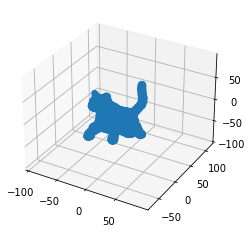

In [8]:
shape = TorchShape(args=_args, device=device)
shape.mesh.show()
shape.plot_embedding(shape.mesh.vertices)

In [9]:
mds_params = MdsConfig.MdsParams(shape, _args)
mds_params.set_shape(shape)
mds_params.set_weights(shape.weights)

[samples, d_mat] = shape.sample_mesh_fps(np.max(mds_params.q), d_mat=_args.d_mat_input)
# [samples, d_mat] = shape.sample_mesh_fps(np.max(mds_params.q))
mds_params.set_samples(samples)

sample_mesh



In [10]:
# create subspace
shape.compute_subspace(max(mds_params.p))
mds = TorchMDS(mds_params, device)
x0 = shape.mesh.vertices
var_type = torch.float64

phi = shape.evecs.type(var_type).to(device).requires_grad_()
d_mat = torch.tensor(d_mat, dtype=var_type, device=device, requires_grad=True)
x0 = torch.tensor(x0, dtype=var_type, device=device, requires_grad=True)

start compute subspace


start algorithm
iter : 20, stress : 211160.829545298
iter : 40, stress : 203381.9141640834
iter : 60, stress : 202862.53365445256
iter : 20, stress : 755596.1362881542
final stress : 755295.5792794167
Forward


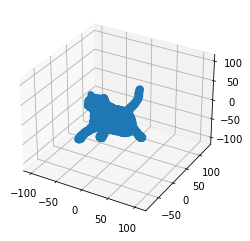

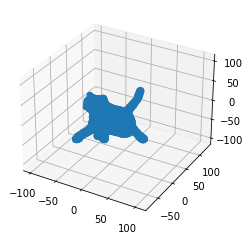

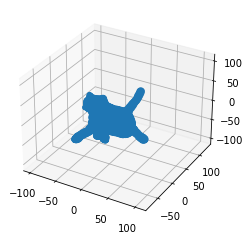

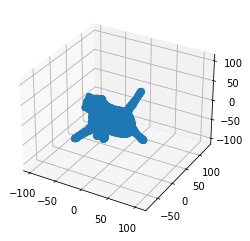

In [11]:
diff_mds = DifferentiableMDS(mds, x0, phi, d_mat)
xn = diff_mds()

In [12]:
loss = sum(xn) ** 2
loss.backward()


Backward
df_dd_s: max=0.002435720680243646, min=-0.002423415064998583
df_dw_s: max=0.041510401258168045, min=-0.04227604327333248
df_d_x_x0_phi_s[0]: max=0.9137945610808346, min=-0.21476385622168107
df_d_x_x0_phi_s[1]: max=0.7851372175191376, min=-0.37721688931436465
df_d_x_x0_phi_s[2]: max=680.7682877821054, min=-353.0661742063269
